# Libraries

In [17]:
## Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import copy
import argparse
import torch
import gc
import sys
from pathlib import Path
from tqdm import tqdm

# path to the directory that CONTAINS the package folder
project_root = Path("/home/benedetti/PL")   # adjust to your real path

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PL.model.model import TwoBodiesModel
from PL.dataset.random_features import RandomDatasetPowerLaw
from PL.utils.saving import init_training_h5, save_training, load_training
from PL.utils.functions import start_overlap, compute_asymmetry, overlap, basins_of_attraction_inp_vectors

from PL.training.training_RF import train_model, initialize

device = torch.device("cuda:2")

data_PATH = "./data"


# Example dataset and model with Hebb

In [30]:
# Nature of variables and loss
d=1
spin_type = "vector"

pick_biased = True

# Step
n = 100

L=3
eta=1.
alpha_P = 1.
alpha_D = 0.1

def compute_overlap_array(N, P, D, d, L, eta, seed):

    dataset = RandomDatasetPowerLaw(P, N, D, d, eta=eta, L=L, seed=seed, spin_type=spin_type, coefficients="binary", shift=0, pick_biased=pick_biased)

    model  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)

    xi = dataset.xi.to(device)
    f =  dataset.f.to(device)

    model.Hebb(xi, "Tensorial")

    x = f.clone()

    for i_n in range(n):
        x = model.dyn_step(x)

    overlap_k = torch.abs(torch.einsum("kia,kia->k", f, x))/N

    return overlap_k.cpu().numpy()


In [31]:
N_arr = np.array([500,1000,2000,4000])
seeds_arr = np.arange(100, 200)

to_save = np.empty((len(N_arr), len(seeds_arr)), dtype=object)

for i_s, seed in tqdm(enumerate(seeds_arr)):
    for i_N, N in enumerate(N_arr):
        P = int(alpha_P*N)
        D = int(alpha_D*N)
        to_save[i_N, i_s] = compute_overlap_array(N, P, D, d, L, eta, seed) 

100it [05:43,  3.43s/it]


In [32]:
means = np.empty(len(N_arr), dtype=object)
std = np.empty(len(N_arr), dtype=object)

for i_N, N in enumerate(N_arr):
    D = int(alpha_D*N)
    arr = np.zeros((len(seeds_arr), D))
    for i_s in range(len(seeds_arr)):
        arr[i_s] = to_save[i_N, i_s]
    means[i_N] = arr.mean(axis=0)
    std[i_N] = arr.std(axis=0)

In [33]:
fname = "curves_eta{}_alpha_P{}_alpha_D{}_L{}".format(eta, alpha_P, alpha_D,L)

final_dict = {
    "means": means,
    "std": std,
    "alpha_P": alpha_P,
    "alpha_D": alpha_D,
    "N_arr": N_arr,
    "seeds_arr": seeds_arr,
    "eta": eta
}

np.savez("/home/benedetti/RF_power_law/data/"+fname, **final_dict )

In [34]:
fname = "curves_eta{}_alpha_P{}_alpha_D{}_L{}.npz".format(eta, alpha_P, alpha_D, L)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)


mean_arr = saved_dict["means"]
std_arr = saved_dict["std"]
N_array = saved_dict["N_arr"]
aD =  saved_dict["alpha_D"]
aP =  saved_dict["alpha_P"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

# Varying eta

In [ ]:
for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

In [ ]:
for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

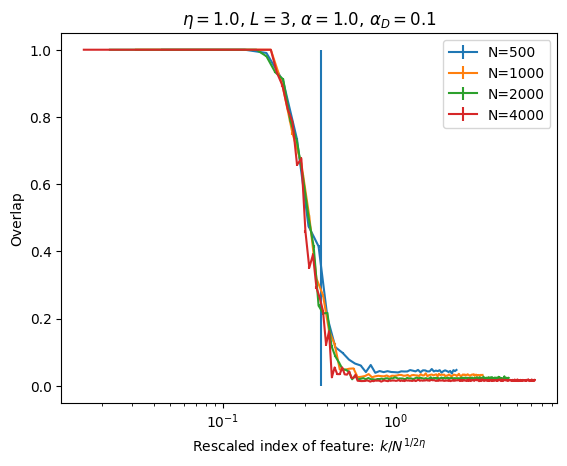

In [35]:
for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

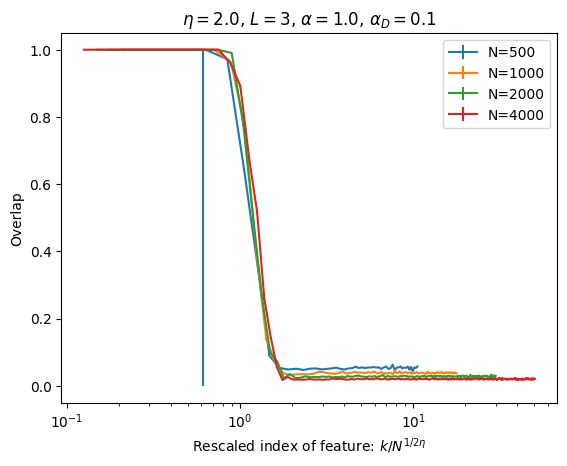

In [29]:
for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

# L=7

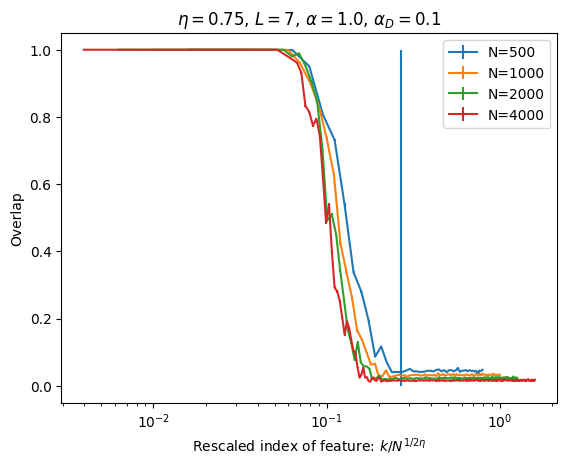

In [16]:
for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()

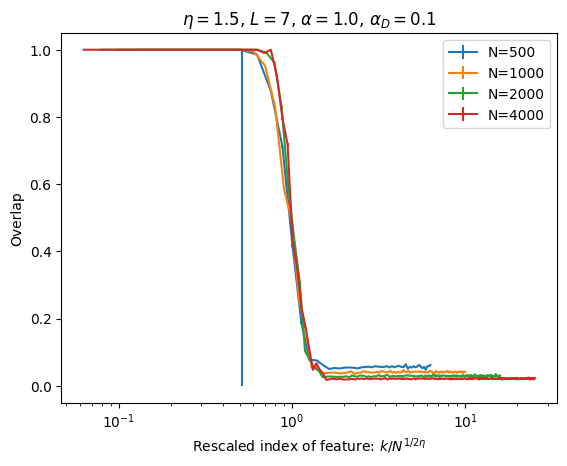

In [23]:
for i_N, N in enumerate(N_array):
    P = int(aP*N)
    D = int(aD*N)
    plt.errorbar(np.arange(1,D+1)/(N**(0.5/eta_value)), mean_arr[i_N], std_arr[i_N]/(float(len(s_arr))), label="N={}".format(N))

plt.vlines(x=(0.138**(0.5/eta)), ymin=0.0, ymax=1.0)

plt.xlabel(r"Rescaled index of feature: $k/N^{1/2\eta}$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $\alpha={alpha_P}$, $\alpha_D={alpha_D}$")
plt.xscale("log")
plt.legend()